$$y''=-y$$
$$y(0) = 0$$
$$y(\pi/2) = 1$$

In [3]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import time
device = "cpu"
dtype = torch.float64
puntosCreados = []
class NeuralNetworkPrueba(nn.Module):
    def __init__(self):
        super(NeuralNetworkPrueba, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


#red=NeuralNetworkPrueba().to(device)
#red.load_state_dict(torch.load("intento1Seno.txt")())
redDinamica = NeuralNetworkPrueba().to(device)

In [18]:

puntos = torch.linspace(0,1.6,20, device = device)

perdidavar = 1e9

def perdidaBase():
    suma=0
    xPi = torch.linspace(3.14159/2,1,2,device = device)
    xPi =  torch.tensor([xPi[0]],device=device,requires_grad =True)
    x0 =  torch.tensor([puntos[0]],device=device,requires_grad =True)
    suma+=40*(redDinamica(x0))**2
    suma+=100*(1-redDinamica(xPi))**2
    return suma


def perdida2():
    global perdidavar
    x0 =  torch.tensor([puntos[0]],device=device,requires_grad =True)
    xPi = torch.linspace(3.14159/2,1,2,device = device)
    xPi =  torch.tensor([xPi[0]],device=device,requires_grad =True)
    suma = 0
    for j in puntos:
        i = torch.tensor([j],device=device,requires_grad =True)
        y = redDinamica(i)
        yprima=torch.autograd.grad(y,i,create_graph=True)[0]
        yprimaprima=torch.autograd.grad(yprima,i,create_graph=True)[0]
        suma+=(yprimaprima+y)**2
    suma+=40*(redDinamica(x0))**2
    suma+=100*(1-redDinamica(xPi))**2
    perdidavar = suma
    return suma

superMax = 0
def actualizarPuntos():
    # Esta función va actualizar los puntos. Para mantener un balance entre puntos nuevos y puntos anteriores
    #  tambien va a cubir el espacio recorrido por puntos anteriores. Un objetivo de esta función es correr 
    # con un numero bajo de puntos
    global perdidavar,puntos,puntosCreados,superMax
    coeficiente = 1e-7 #este coeficiente es para alentizar el avance con respecto a la función de perdiad
    nuevosPuntos = puntos.detach().tolist()
    nuevoPunto = max(min(superMax+coeficiente/perdidavar,10),0)  # acá se da el avance en promedio
    nuevoPunto = max(min(rd.normalvariate(nuevoPunto,0.01),10),0) # acá se da el avance como una distribución normal
    nuevosPuntos.append(nuevoPunto)
    puntosCreados.append(nuevoPunto)
    tamTensor = 80
    borra = 35
    anade = 10
    if nuevoPunto>superMax:
        superMax = nuevoPunto
    if abs(superMax - 10) < 0.1:
        superMax = 0
    if len(nuevosPuntos)>tamTensor:
        for i in range(borra):
            indice = rd.randint(0,tamTensor-borra-2)
            nuevosPuntos.pop(indice)
        for i in range(anade):
            nuevosPuntos.append(rd.uniform(0,superMax))
    puntos = torch.tensor(nuevosPuntos,device = device)

In [4]:
learning_rate = 1e-5
epochs = 8000
optimizer = torch.optim.Adam(redDinamica.parameters(), lr=learning_rate)
registro_perdida=[]
tiempoInicial = time.time()
i = 0
while time.time()-tiempoInicial<3600/4:
    # Compute prediction and loss
    loss = perdidaBase()
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(loss.item()/len(puntos))
        #actualizarPuntos()
    registro_perdida.append(loss.item()/len(puntos))
    i+=1

3.7787593841552733
3.153718185424805
2.5635656356811523
1.9831096649169921
1.4379691123962401
0.9808279991149902
0.6471035003662109
0.4280413627624512
0.28574700355529786
0.186960768699646
0.11571898460388183
0.06612973213195801
0.0344115823507309
0.016192567348480225
0.006876528263092041
0.002639362961053848
0.0009185477159917354
0.00029081408865749836
8.39524669572711e-05
2.2110971622169016e-05
5.307803439791314e-06
1.1583058039832394e-06
2.2911322048457805e-07
4.1382691051694565e-08
7.498395859784068e-09
1.9864309308559313e-09
8.405534046573848e-10
4.399081099393243e-10
2.622631001258924e-10
1.6799550639490235e-10
1.1116008113987164e-10
7.629108456086442e-11
5.420466853145456e-11
4.049383051096811e-11
3.085379174372349e-11
2.180480795921369e-11
1.759703494030873e-11
1.2483458711187723e-11
9.484885099553253e-12
7.0843608757087395e-12
5.44553291348393e-12
4.000799691539214e-12
3.873457110614709e-12
2.7080837572412975e-12
2.3191448761394895e-12
1.6915358003188885e-12
1.2137235660958368

KeyboardInterrupt: 

In [20]:
learning_rate = 1e-5
epochs = 8000
optimizer = torch.optim.Adam(redDinamica.parameters(), lr=learning_rate)
#registro_perdida=[]
tiempoInicial = time.time()
i = 0
while time.time()-tiempoInicial<3600*1.5:
    # Compute prediction and loss
    loss = perdida2()
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(loss.item()/len(puntos))
        actualizarPuntos()
    registro_perdida.append(loss.item()/len(puntos))
    i+=1

0.5390322208404541
0.410465331304641
0.3268874558535489
0.2716107161148735
0.23039650917053223
0.1964244079589844
0.16763202960674578
0.14326789644029406
0.12265115124838692
0.10516478275430613
0.0903298298517863
0.077753113162133
0.06709480285644531
0.05807015028866855
0.05042864995844224
0.04395552703312465
0.03846601314014859
0.03380623701456431
0.02983405401832179
0.026436738478831757
0.02352064847946167
0.021008664514960314
0.018829809767859324
0.016936101192651792
0.015273751182989641
0.013799015680948894
0.012491889621900476
0.01132228526663273
0.010267755016684532
0.009315544245194415
0.008451899290084839
0.007667121933955772
0.006951183080673218
0.006297498941421509
0.005704248393023455
0.005159508640115911
0.004665397107601166
0.004219043673130504
0.003813290647391615
0.0034490664631633434
0.003121835986773173
0.002827763557434082
0.0025649231768423513
0.002329473694165548
0.002120411489158869
0.0019349286189446083
0.0017705358790628838
0.0016256788773323172
0.001497376162339

In [7]:
torch.save(red.state_dict(),"intento1SenoPuntosDinamicos.txt")
plt.figure(figsize = (20,10))
plt.semilogy(registro_perdida)

NameError: name 'red' is not defined

Los puntos deben parar cuando el gradiente llegue a un punto cercano a acero. este punto cercano a o puede ser un 100 avo del valor de lectura original del gradiente o cuando salgan del dominio. 

$$y'' = -y$$
$$y(0) = 0$$

In [8]:
import time
inicial = time.time()
print(time.time()-inicial)
time.sleep(2)
print(time.time()-inicial)
time.sleep(3)
print(time.time()-inicial)

0.0
2.006734848022461
5.013559579849243


<ipython-input-19-f91ac3a461ed>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(puntosGrafica,np.sin(puntosGrafica),label = "referencia",LineStyle="-.")


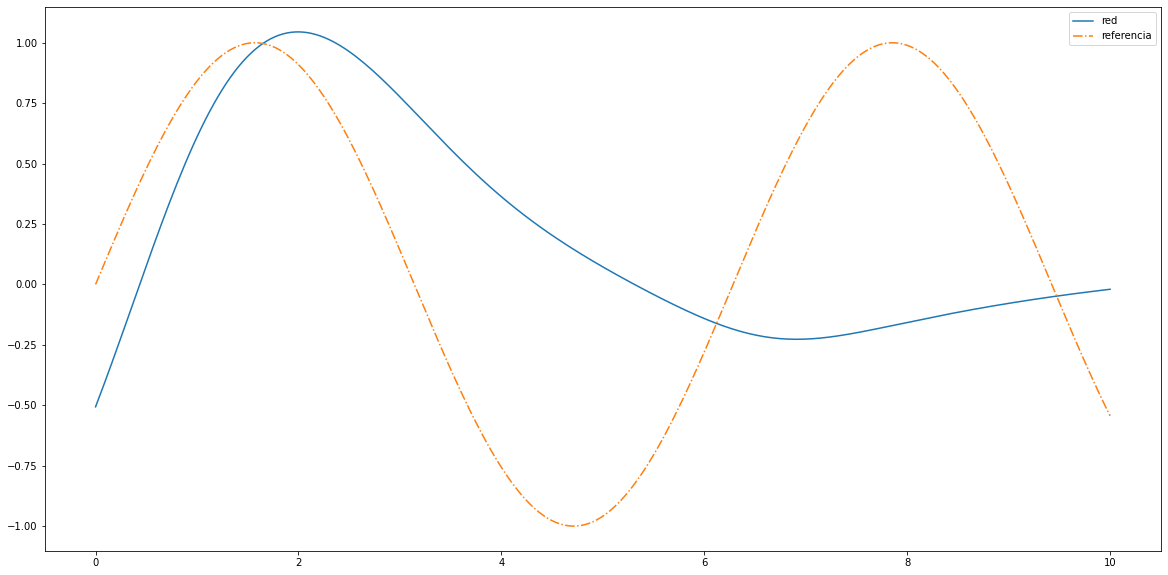

In [19]:
ygrafica = []
puntosGrafica = torch.linspace(0,10,250)
for i in puntosGrafica:
    ytemp=redDinamica(torch.tensor([i],device = device))
    #ygrafica.append(ytemp.cpu().detach().numpy()[0])
    ygrafica.append(ytemp.detach().numpy()[0])
import numpy as np
puntosGrafica = np.linspace(0,10,250)
plt.figure(figsize = (20,10))
plt.plot(puntosGrafica,ygrafica,label = "red")
plt.plot(puntosGrafica,np.sin(puntosGrafica),label = "referencia",LineStyle="-.")
plt.legend()

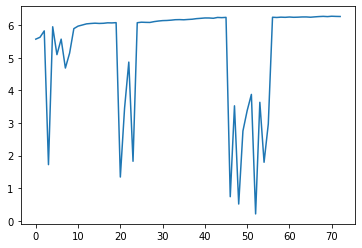

In [16]:
plt.plot(puntos.detach().numpy())